# Project Milestone Two

**Data Preparation and Model Exploration**
**Due:** Midnight on November 16th with usual 2-hour grace period — **worth 100 points**

**Note: No late assignments accepted, we need the time to grade them!**

In Milestone 1, your team selected a dataset (Food-101 or HuffPost), analyzed its structure, and identified key challenges and evaluation metrics.
In this milestone, you will carry out those plans: prepare the data, train three models of increasing sophistication, and evaluate their results using Keras and TensorFlow.
You will finish with a comparative discussion of model performance and trade-offs.


### Submission Guidelines

* Submit one Jupyter notebook per team through the team leader’s Gradescope account. **Include all team members names at the top of the notebook.** 
* Include all code, plots, and answers inline below.
* Ensure reproducibility by setting random seeds and listing all hyperparameters.
* Document any AI tools used, as required by the CDS policy.


### (Peter Note) - Ignore this cell (I need this to run the models locally), not needed if used on colab.

In [2]:
# Add this at the TOP of your notebook or in a new cell
import tensorflow as tf

# Clear any previous sessions
tf.keras.backend.clear_session()

# Reset GPU memory
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✓ GPU memory growth enabled for {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(f"Error: {e}")

✓ GPU memory growth enabled for 1 GPU(s)


### Import Strategy 
1. `Useful Imports`
2. `Load Datasets` (grab from the repo)

In [3]:
# ============================================
# Useful Imports
# ============================================

# --- Standard Libraries
import os
import time
import math
import random
from collections import Counter

# --- Core Data / Numerics
import numpy as np
import pandas as pd

# --- Visualization
import matplotlib.pyplot as plt
# import seaborn as sns              # optional
import matplotlib.ticker as mticker  # optional (for formatted axes)

# --- NLP / Tokenization
import spacy                         # used for text preprocessing (HuffPost)

# --- Progress Tracking
from tqdm import tqdm                # optional (nice for loops)

from IPython.display import display

# --- TensorFlow / Keras (Deep Learning)
import tensorflow as tf
from tensorflow.keras import layers, models, Input, callbacks, regularizers, initializers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, MaxPooling2D, Conv2D,
    SeparableConv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
)

from tensorflow.keras import layers, models, Input, Sequential
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split

# hugging face
# --- Hugging Face Datasets
from datasets import load_dataset, DatasetDict
from datasets.features import ClassLabel

# --- (Optional) Classical ML Baseline Tools
# from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score


# ============================================
# Global Configuration & Small Utilities
# ============================================

# Reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)   # sets Python, NumPy, and TensorFlow seeds

# Utility: format seconds as HH:MM:SS

"""
Example usage to time your code:

start_time = time.time()
# ... your code here ...
print("Execution Time:", format_hms(time.time() - start_time))
"""

def format_hms(seconds: float) -> str:
    """Convert seconds to HH:MM:SS format."""
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

# load dataset
from datasets import load_from_disk
print("loading huffpost dataset")
huff_all = load_from_disk("huffpost_splits")  # reload when needed

loading huffpost dataset


## Problem 1 – Data Preparation and Splits (20 pts)

### Goals

Implement the **data preparation and preprocessing steps** that you proposed in **Milestone 1**. You’ll clean, normalize, and split your data so that it’s ready for modeling and reproducible fine-tuning.

### Steps to Follow

1. **Load your chosen dataset**

   * Use `datasets.load_dataset()` from **Hugging Face** to load **Food-101** or **HuffPost**.
   * Display basic information (e.g., number of samples, feature names, example entries).

2. **Apply cleaning and normalization**

   * **Images:**

     * Ensure all images are in RGB format.
     * Resize or crop to a consistent shape (e.g., `224 × 224`).
     * Drop or fix any corrupted files.
   * **Text:**

     * Concatenate headline + summary (for HuffPost).
     * Strip whitespace, convert to lowercase if appropriate, and remove empty samples.
     * Optionally remove duplicates or extremely short entries.

3. **Standardize or tokenize the inputs**

   * **Images:**

     * Normalize pixel values (e.g., divide by 255.0).
     * Define a minimal augmentation pipeline (e.g., random flip, crop, or rotation).
   * **Text:**

     * Create a tokenizer or `TextVectorization` layer.
     * Set a target `max_length` based on your analysis from Milestone 1 (e.g., 95th percentile).
     * Apply padding/truncation and build tensors for input + labels.

4. **Handle dataset-specific challenges**

   * If you identified **class imbalance**, compute label counts and, if needed, create a dictionary of `class_weights`.
   * If you noted **length or size variance**, verify that your truncation or resizing works as intended.
   * If you planned **noise filtering**, include the cleaning step and briefly explain your criteria (e.g., remove items with missing text or unreadable images).

5. **Create reproducible splits**

   * Split your cleaned dataset into **train**, **validation**, and **test** subsets (e.g., 80 / 10 / 10).
   * Use a fixed random seed for reproducibility (`random_seed = 42`).
   * Use **stratified splits**  (e.g., with `train_test_split` and `stratify = labels`).
   * Display the size of each subset.

6. **Document your pipeline**

   * Summarize your preprocessing steps clearly in Markdown or code comments.
   * Save or display a few representative examples after preprocessing to confirm the transformations are correct.


## Import dataset and run Emma data cleaning/tokenization scripts

In [15]:
# Your code here; add as many cells as you need but make it clear what the structure is. 
from sklearn.utils.class_weight import compute_class_weight
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

# combine headline & short_description into 1 text field
def combine_fields(prob2):
  headline = prob2.get('headline', '') or ""
  short_desc = prob2.get('short_description', '[NO_DESC]') or "[NO_DESC]"
  prob2['text'] = f"{headline} [SEP] {short_desc}"
  return prob2

huff_all = huff_all.map(combine_fields)
print(huff_all.column_names)
print(huff_all[0])

# write to pandas
df_prob2 = huff_all.to_pandas()

# Solution 1: Merge Duplicate/Overlapping Categories
merge_map = {
    'WORLDPOST': 'WORLD NEWS',
    'ARTS': 'ARTS & CULTURE',
    'ARTS & CULTURE': 'CULTURE & ARTS',
    'STYLE': 'STYLE & BEAUTY',
    'PARENTS': 'PARENTING'
    }
df_prob2['category'] = df_prob2['category'].replace(merge_map)

# Solution 2: Handle Missing short_description
df_prob2['short_description'] = df_prob2['short_description'].replace('','[NO_DESC]').fillna('[NO_DESC]')

# Solution 3: Combine headline and short_description into a single field to avoid short text length
df_prob2['headline'] = df_prob2['headline'].fillna('')
df_prob2['text'] = df_prob2['headline'] + " [SEP] " + df_prob2['short_description']

# Solution 4: Deduplicating
df_prob2 = df_prob2.drop_duplicates(subset=["text"]).reset_index(drop=True)

# Solution 5: Stratified Split with train/val/test/split
train_df, temp_df = train_test_split(
    df_prob2,
    test_size=0.30,
    stratify=df_prob2['category'],
    random_state=42
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,  # Split temp equally into val/test (15% each of total)
    stratify=temp_df['category'],
    random_state=42
)

# convert splits back to Hugging Face Datasets
train_ds = Dataset.from_pandas(train_df[['text', 'category']], preserve_index=False)
val_ds   = Dataset.from_pandas(val_df[['text', 'category']], preserve_index=False)
test_ds  = Dataset.from_pandas(test_df[['text', 'category']], preserve_index=False)


# Solution 6: Compute/Apply Class Weights to handle Imbalance
categories = np.unique(df_prob2['category'])
weights = compute_class_weight(
    class_weight='balanced',
    classes=categories,
    y=df_prob2['category']
)

print('\nClass weights examples:')
print(dict(zip(categories[:5], weights[:5])))

# Solution 7: Tokenization with DistilBERT & max_length=128
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_fn(batch):
  return tokenizer(
      batch['text'],
      padding='max_length',
      truncation=True,
      max_length=128, 
      return_tensors='tf'
  )
train_ds = train_ds.map(tokenize_fn, batched=True)
val_ds   = val_ds.map(tokenize_fn, batched=True)
test_ds  = test_ds.map(tokenize_fn, batched=True)


# Solution 8: Label Encode category column into integers
le = LabelEncoder()
all_labels = list(train_ds['category']) + list(val_ds['category']) + list(test_ds['category'])
le.fit(all_labels)
num_labels = len(le.classes_)

def encode_labels(batch):
    batch['labels'] = le.transform([batch['category']])[0]
    return batch

train_ds = train_ds.map(encode_labels)
val_ds   = val_ds.map(encode_labels)
test_ds  = test_ds.map(encode_labels)

Map:   0%|          | 0/200853 [00:00<?, ? examples/s]

['category', 'headline', 'authors', 'link', 'short_description', 'date', 'text']
{'category': 'CRIME', 'headline': 'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV', 'authors': 'Melissa Jeltsen', 'link': 'https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89', 'short_description': 'She left her husband. He killed their children. Just another day in America.', 'date': datetime.datetime(2018, 5, 26, 0, 0), 'text': 'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV [SEP] She left her husband. He killed their children. Just another day in America.'}

Class weights examples:
{'ARTS & CULTURE': 3.588648290437555, 'BLACK VOICES': 1.1972739929848044, 'BUSINESS': 0.9127372779825165, 'COLLEGE': 4.733627858627859, 'COMEDY': 1.048658069378441}


Map:   0%|          | 0/140255 [00:00<?, ? examples/s]

Map:   0%|          | 0/30055 [00:00<?, ? examples/s]

Map:   0%|          | 0/30055 [00:00<?, ? examples/s]

Map:   0%|          | 0/140255 [00:00<?, ? examples/s]

Map:   0%|          | 0/30055 [00:00<?, ? examples/s]

Map:   0%|          | 0/30055 [00:00<?, ? examples/s]

## Utilities - load and save datasets

In [4]:
# save datasets to disk for future reload
from datasets import DatasetDict
import pickle

# Create a DatasetDict
processed_datasets = DatasetDict({
    'train': train_ds,
    'validation': val_ds,
    'test': test_ds
})

# save to disk
processed_datasets.save_to_disk("huffpost_processed_milestone2")

# save the label encoder
import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)
print("Label encoder saved to label_encoder.pkl")

# save class weights as well
class_weights = weights 
np.save('class_weights.npy', class_weights)
print("Class weights saved to class_weights.npy")

NameError: name 'train_ds' is not defined

### Load Datasets

In [6]:
# For quick reload! 
import pickle
from datasets import load_from_disk

processed_datasets = load_from_disk("huffpost_processed_milestone2")
train_ds = processed_datasets['train']
val_ds = processed_datasets['validation']
test_ds = processed_datasets['test']

with open('data/label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

# Load weights
class_weights = np.load('data/class_weights.npy')

# Use as TF tensor when needed
class_weights_tf = tf.constant(class_weights, dtype=tf.float32)
num_labels = len(le.classes_)

print(f"Loaded: Train={len(train_ds)}, Val={len(val_ds)}, Test={len(test_ds)}")

# Create string arrays for baseline model
print("Preparing data for baseline model...")
X_train = np.array(train_ds['text'], dtype=object)
X_val = np.array(val_ds['text'], dtype=object)  
X_test = np.array(test_ds['text'], dtype=object)

y_train = np.array(train_ds['category'])
y_val = np.array(val_ds['category'])
y_test = np.array(test_ds['category'])

print(f"Data types: X_train={X_train.dtype}, y_train={y_train.dtype}")
print(f"Shapes: X_train={X_train.shape}, X_val={X_val.shape}")

# Binarize labels
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_train_enc = lb.fit_transform(y_train)
y_val_enc = lb.transform(y_val)
y_test_enc = lb.transform(y_test)

print(f"Data ready for baseline model (strings)")

Loaded: Train=140255, Val=30055, Test=30055
Preparing data for baseline model...
Data types: X_train=object, y_train=<U14
Shapes: X_train=(140255,), X_val=(30055,)
Data ready for baseline model (strings)


### Helper Function - Get Misclassified Samples 

In [17]:
def get_misclassified_samples(model, X_test, y_test, model_type='keras', 
                              n_samples=5, le=None, tokenizer=None, device=None, X_test_original=None):
    """
    Extract misclassified samples from any of the three model architectures.
    
    Parameters:
    -----------
    model : keras.Model or torch.nn.Module
        Trained model to evaluate
    X_test : np.array or Dataset
        Test data (can be vectorized for keras models, HF Dataset for PyTorch)
    y_test : np.array
        True labels (category names as strings)
    model_type : str
        One of ['keras', 'pytorch']
        - 'keras': For baseline and CNN models (uses model.predict)
        - 'pytorch': For DistilBERT model (uses PyTorch forward pass)
    n_samples : int
        Number of misclassified samples to return per category (default: 5)
    le : LabelEncoder
        Label encoder for converting between indices and category names
    tokenizer : AutoTokenizer (optional)
        Required for pytorch model type
    device : torch.device (optional)
        Required for pytorch model type
    X_test_original : np.array (optional)
        Original raw text when X_test contains vectorized/encoded data
        If not provided, assumes X_test contains raw text
        
    Returns:
    --------
    pd.DataFrame with columns:
        - text: Original text
        - true_label: Actual category
        - predicted_label: Model's prediction
        - confidence: Prediction confidence
        - true_label_idx: True label index
        - pred_label_idx: Predicted label index
    """
    import numpy as np
    import pandas as pd
    
    if model_type == 'keras':
        # Get predictions as probabilities
        y_pred_probs = model.predict(X_test, batch_size=512, verbose=0)
        predicted_indices = y_pred_probs.argmax(axis=1)
        
        # Get true label indices
        true_indices = le.transform(y_test)
        
        # Get confidences (max probability for each prediction)
        confidences = y_pred_probs.max(axis=1)
        
        # Original texts - use X_test_original if provided (for vectorized inputs)
        # otherwise use X_test (for raw text inputs)
        if X_test_original is not None:
            texts = X_test_original if isinstance(X_test_original, np.ndarray) else np.array(X_test_original)
        else:
            texts = X_test if isinstance(X_test, np.ndarray) else np.array(X_test)
        
    elif model_type == 'pytorch':
        import torch
        from torch.utils.data import DataLoader
        from tqdm import tqdm
        
        if tokenizer is None or device is None:
            raise ValueError("tokenizer and device are required for pytorch model")
        
        # Prepare dataset
        test_dataset = X_test.map(
            lambda x: tokenizer(x['text'], padding='max_length', truncation=True, max_length=128),
            batched=True,
            batch_size=1000
        )
        test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
        test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)
        
        model.eval()
        all_preds = []
        all_probs = []
        all_labels = []
        
        with torch.no_grad():
            for batch in tqdm(test_loader, desc="Getting predictions"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                probs = torch.softmax(logits, dim=1)
                
                _, predicted = torch.max(logits, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        predicted_indices = np.array(all_preds)
        true_indices = np.array(all_labels)
        y_pred_probs = np.array(all_probs)
        confidences = y_pred_probs.max(axis=1)
        
        # Get original texts from dataset
        texts = np.array(X_test['text'])
        
    else:
        raise ValueError(f"model_type must be 'keras' or 'pytorch', got {model_type}")
    
    # Find misclassified samples
    misclassified_mask = predicted_indices != true_indices
    misclassified_indices = np.where(misclassified_mask)[0]
    
    print(f"Total misclassified: {len(misclassified_indices)} / {len(y_test)} "
          f"({100 * len(misclassified_indices) / len(y_test):.2f}%)")
    
    # Create dataframe of all misclassified samples
    misclassified_df = pd.DataFrame({
        'text': texts[misclassified_indices],
        'true_label': le.inverse_transform(true_indices[misclassified_indices]),
        'predicted_label': le.inverse_transform(predicted_indices[misclassified_indices]),
        'confidence': confidences[misclassified_indices],
        'true_label_idx': true_indices[misclassified_indices],
        'pred_label_idx': predicted_indices[misclassified_indices]
    })
    
    # Sample n_samples from each true category
    sampled_dfs = []
    for category in le.classes_:
        category_misclassified = misclassified_df[misclassified_df['true_label'] == category]
        if len(category_misclassified) > 0:
            # Sample up to n_samples, or all if fewer available
            n = min(n_samples, len(category_misclassified))
            sampled = category_misclassified.sample(n=n, random_state=42)
            sampled_dfs.append(sampled)
    
    result_df = pd.concat(sampled_dfs, ignore_index=True)
    result_df = result_df.sort_values('true_label').reset_index(drop=True)
    
    return result_df


def display_misclassified_samples(df, max_text_length=200):
    """
    Pretty print misclassified samples.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Output from get_misclassified_samples
    max_text_length : int
        Maximum text length to display (truncate longer texts)
    """
    for idx, row in df.iterrows():
        print(f"\n{'='*80}")
        print(f"Sample {idx + 1}")
        print(f"{'='*80}")
        
        # Truncate text if too long
        text = row['text']
        if len(text) > max_text_length:
            text = text[:max_text_length] + "..."
        
        print(f"Text: {text}")
        print(f"\nTrue Label:      {row['true_label']}")
        print(f"Predicted Label: {row['predicted_label']}")
        print(f"Confidence:      {row['confidence']:.4f}")
        print(f"{'='*80}")

### Graded Questions (5 pts each)

For each question, answer thoroughly but concisely, in a short paragraph, longer or shorter as needed. Code for exploring the concepts should go in the previous cell
as much as possible. 

1. **Data Loading and Cleaning:**
   Describe how you loaded your dataset and the key cleaning steps you implemented (e.g., handling missing data, normalizing formats, or removing duplicates).

1.1. **Your answer here:**

        The raw dataset was loaded directly from Hugging Face and each record includes a headline, a short decription, a category, authors, and the date of publication. The headline and short_descriptions were merged and extra whitespaced removed. The categories were then normalized and overlapping categories were combined. Any missing data was replaced with empy strings to allow to tokenization later. Duplicates were dropped who had the same headline and short_description.


2. **Preprocessing and Standardization:**
   Summarize your preprocessing pipeline. Include any normalization, tokenization, resizing, or augmentation steps, and explain why each was necessary for your dataset.
  

1.2. **Your answer here:**

        Normalization steps included the removal of any excessive whitesapce using regex, missing text was filled with an empty string or [NO_DESC] to allow for later tokenization, and duplicate entries with the same headline and short_description were dropped. DistilBERT was selected as our tokenizer and included padding of the 'max_length' set to 128 and truncation. This tokenization is important since it makes sure all sequences have the same length and are mapped to their corresponding input_ids. Additionally, we used label encoding to convert all categories into IDs and class weight normalization to handle category imbalance present in the dataset to prevent bias towards dominant new topics and improve model generalization.

3. **Train/Validation/Test Splits:**
   Explain how you divided your data into subsets, including the split ratios, random seed, and any stratification or leakage checks you used to verify correctness.


1.3. **Your answer here:**

        After cleaning and normalization, the dataset was divided into training, validation, and test sets and splits were stratifid by category. The data was split into a 70/15/15 split which we deemed would likely preserve plenty of samples in both the validation and test sets to create a robust model. Stratification was used during the train_test_split to maintain balance in the categories. It is important to note that splitting was done after data cleaning and normalization to prevent duplicate information and data leakage.


4. **Class Distribution and Balance:**
   Report your label counts and describe any class imbalances you observed. If applicable, explain how you addressed them (e.g., weighting, oversampling, or data augmentation).


1.4. **Your answer here:**

        The outputs from the split after data normalization, cleaning, and tokenization indicate that the proportions were consistent for each category and roughly equal across all subsets. This indicates that our stratification worked as intended and there is minimal data leakage or bias detected. For example, the POLITICS category after splitting has a train frequency of 16.3% which is identical to the validation and test frequencies which are also at 16.3%.

## Problem 2 – Baseline Model (20 pts) (Plus get the helper functions all imported into the notebook week 7) (Emma)

### Goal
Build and train a **simple, fully functional baseline model** to establish a reference level of performance for your dataset.
This baseline will help you evaluate whether later architectures and fine-tuning steps actually improve results.

### Steps to Follow

1. **Construct a baseline model**

   * **Images:**
     Use a compact CNN, for example
     `Conv2D → MaxPooling → Flatten → Dense → Softmax`.
   * **Text:**
     Use a small embedding-based classifier such as
     `Embedding → GlobalAveragePooling → Dense → Softmax`.
   * Keep the model small enough to train in minutes on Colab.

2. **Compile the model**

   * Optimizer: `Adam` or `AdamW`.
   * Loss: `categorical_crossentropy` (for multi-class).
   * Metrics: at least `accuracy`; add `F1` if appropriate.

3. **Train and validate**

   * Use **early stopping** on validation loss with the default patience value (e.g., 5 epochs).
   * Record number of epochs trained and total runtime.

4. **Visualize results**

   * Plot **training vs. validation accuracy and loss**.
   * Carefully observe: does the model underfit, overfit, or generalize reasonably?

5. **Report baseline performance**

   * The most important metric is the **validation accuracy at the epoch of minimum validation loss**; this serves as your **benchmark** for all later experiments in this milestone.
   * Evaluate on the **test set** and record final metrics.

In [8]:
# Your code here; add as many cells as you need but make it clear what the structure is. 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

num_classes = len(lb.classes_)
print("number of classes:", num_classes)

# Vectorization
max_vocab = 60000
max_len = 128
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=max_vocab,
    output_sequence_length=max_len,
    standardize='lower_and_strip_punctuation'
)
vectorizer.adapt(X_train)

# Baseline Model
embedding_dim = 128

inputs = tf.keras.Input(shape=(1,), dtype=tf.string)
x = vectorizer(inputs)
x = tf.keras.layers.Embedding(input_dim=max_vocab, output_dim=embedding_dim)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

baseline_model = tf.keras.Model(inputs, outputs)
baseline_model.summary()

# Put model together
baseline_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

start_time = time.time()
history = baseline_model.fit(
    X_train, y_train_enc,
    validation_data=(X_val, y_val_enc),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

print(f"Training completed in {round(time.time() - start_time, 2)} seconds.")

number of classes: 37


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 128)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 128, 128)       │     7,680,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 37)             │         4,773 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,701,285 (29.38 MB)

 Trainable params: 7,701,285 (29.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
4383/4383 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.3487 - loss: 2.5011 - val_accuracy: 0.5056 - val_loss: 1.8733
Epoch 2/20
4383/4383 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.5346 - loss: 1.7331 - val_accuracy: 0.5763 - val_loss: 1.5724
Epoch 3/20
4383/4383 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6074 - loss: 1.4363 - val_accuracy: 0.5994 - val_loss: 1.4714
Epoch 4/20
4383/4383 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6506 - loss: 1.2548 - val_accuracy: 0.6158 - val_loss: 1.4189
Epoch 5/20
4383/4383 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6844 - loss: 1.1180 - val_accuracy: 0.6163 - val_loss: 1.4340
Epoch 6/20
4383/4383 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7109 - loss: 1.0174 - val_accuracy: 0.6173 - val_loss: 1.4535
Epoch 7/20
4383/4383 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7345 - loss: 0.9238 - val_accuracy: 0.6071 - val_loss: 1.5811
Epoch 8/20
4383/4383 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7538 - loss: 0.8482 -

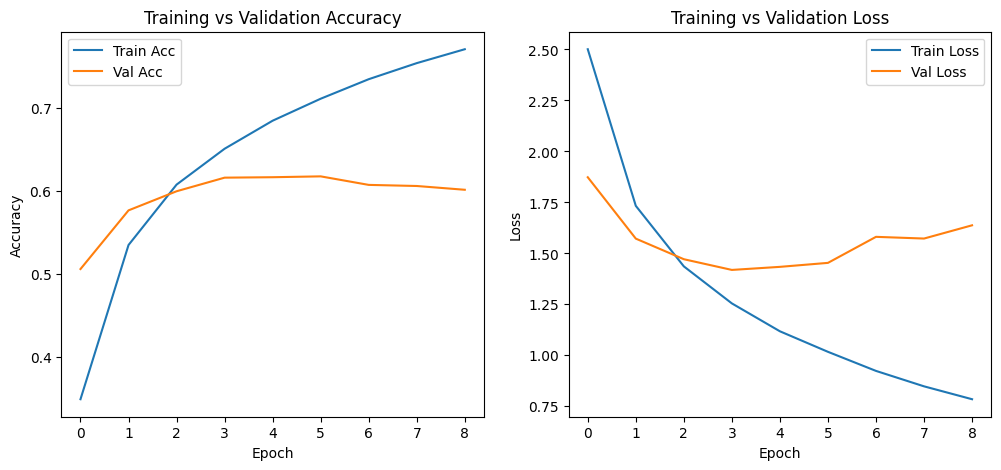

In [9]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [10]:
# Evaluate on test set
test_loss, test_acc = baseline_model.evaluate(X_test, y_test_enc)
print(f"\n Baseline Test Accuracy: {test_acc:.4f}")

from sklearn.metrics import classification_report
y_pred_probs = baseline_model.predict(X_test)
y_pred = lb.classes_[y_pred_probs.argmax(axis=1)]

macro_f1 = f1_score(y_test, y_pred, average='macro')
print("Macro F1:", macro_f1)

report = classification_report(y_test, y_pred, target_names=le.classes_)
print(report)

print(classification_report(y_test, y_pred, digits=4))

940/940 ━━━━━━━━━━━━━━━━━━━━ 1s 966us/step - accuracy: 0.6170 - loss: 1.4236

 Baseline Test Accuracy: 0.6170
940/940 ━━━━━━━━━━━━━━━━━━━━ 1s 575us/step
Macro F1: 0.4523745642902305
                precision    recall  f1-score   support

ARTS & CULTURE       0.44      0.13      0.20       226
  BLACK VOICES       0.54      0.33      0.41       678
      BUSINESS       0.48      0.48      0.48       890
       COLLEGE       0.40      0.21      0.28       172
        COMEDY       0.50      0.37      0.43       774
         CRIME       0.53      0.55      0.54       510
CULTURE & ARTS       0.37      0.32      0.34       355
       DIVORCE       0.82      0.70      0.75       513
     EDUCATION       0.54      0.17      0.26       150
 ENTERTAINMENT       0.57      0.77      0.66      2408
   ENVIRONMENT       0.33      0.40      0.36       199
         FIFTY       0.31      0.10      0.16       210
  FOOD & DRINK       0.59      0.80      0.68       934
     GOOD NEWS       0.27      0.

In [11]:
# Get misclassified samples from Baseline model
# Uncomment and run after training the baseline model:

misclassified_baseline = get_misclassified_samples(
     model=baseline_model,
     X_test=X_test,  # Raw text strings
     y_test=y_test,  # Category names
     model_type='keras',
     n_samples=3,  # 3 samples per category
     le=le
)
 
# Display first 10 misclassified samples
display_misclassified_samples(misclassified_baseline.head(10))
 
# Save to CSV for analysis
misclassified_baseline.to_csv('misclassified_baseline.csv', index=False)
print(f"\nSaved {len(misclassified_baseline)} samples to misclassified_baseline.csv")

Total misclassified: 11512 / 30055 (38.30%)

Sample 1
Text: When the Bubble Bursts [SEP] Two new films shown at CAAMFest 2014 examine what happens when the bubble of supposed perfection bursts and people must struggle to save face while scrambling to hide thei...

True Label:      ARTS & CULTURE
Predicted Label: ENTERTAINMENT
Confidence:      0.4200

Sample 2
Text: 11 Artists You Should Pay Attention To Next Year [SEP] [NO_DESC]

True Label:      ARTS & CULTURE
Predicted Label: ENTERTAINMENT
Confidence:      0.2574

Sample 3
Text: The Many (Portrait) Faces of Virginia Woolf [SEP] [NO_DESC]

True Label:      ARTS & CULTURE
Predicted Label: MEDIA
Confidence:      0.1280

Sample 4
Text: Chance The Rapper Graces GQ Cover, Talks Kanye And Rapper Stereotypes [SEP] “I don’t think I ever wanted to be like Kanye in personality."

True Label:      BLACK VOICES
Predicted Label: ENTERTAINMENT
Confidence:      0.6705

Sample 5
Text: The Teaser For Michel’le's Biopic On 'Surviving Compton' Is Intens

### Graded Questions (5 pts each)

1. **Model Architecture:**
   Describe your baseline model and justify why this structure suits your dataset.

2.1. **Your answer here:**

        The baseline model architecture created has 5 layers total. The input layer takes in the tokenized headline and short_description. The embedding layer then converts the tokens into vectors with a max vocab of 20,000 and shortens them to vectors of a max length of 128. This layer is used to capture the semantic meaning of the words and relationships present. The next layer is the GlobalAveragePooling Layer which takes the average of all embeddings and produces fixed-size vectors for all the samples in order to reduce overfitting and keep the model lightweight. This layer is especially important since it makes sure that different length inputs don't break the model. The fourth layer in this baseline model is the Hidden Dense Layer which utilizes ReLU activation to map the pooled embeddings to features used for classification. The final layer is the output layer which is a dense layer that uses softmax activation and produces a set of probabilities for each category.

        This baseline model is efficient and trains very quickly. The use of pooling in this model reduces the overall risk of overfitting commonly associated with multi-class problems.

2. **Training Behavior:**
   Summarize the model’s training and validation curves. What trends did you observe?

2.2. **Your answer here:**

        The plots generated provide key insights into the effectiveness of the model. Initially, the validation accuracy is greater than the training accuracy which indicates that the model is learning. At epoch 2, the training accuracy increases above the validation accuracy and keeps a fairly high updwards trajectory. While we were expecting the training accuracy to increase, this significant increase in the gap between the curve indicates some overfitting is occuring. This is confirmed by the fact that the validation loss is increasing while the training loss continues to decrease.


  3. **Baseline Metrics:**
   Report validation and test metrics. What does this performance tell you about dataset difficulty?

2.3. **Your answer here:**

        The test accuracy is ~0.60 which indicates taht 60% of the samples will be predicted correctly by the model. The Macro-F1 score is 0.43. Since Macro-F1 is the average per-class, it is not surprising that this value is lower than the test accuracy since despite the use of stratification in pre-processing, many classes are underrepresented which results in low F1 scores for those classes.


  4. **Reflection:**
   What are the main limitations of your baseline? Which specific improvements (depth, regularization, pretraining) would you try next?
  

2.4. **Your answer here:**

        Based upon the output F1 and accuracy metrics and the plots of training behavior, it is clear this model can be significantly improved. The baseline model is too small and does not have enough layers or complexity to capture all of the patterns present in the dataset for all 37 classes. Additionally, there is still a class imbalance that affects the model's performance. This can be remedied by the implementation of class weights during model training to weight the rare classes higher and eliminate some class size bias. Additionally, the use of DistilBERT or a pretrained model could significantly improve the model accuracy and F1 metric outputs.


## Problem 3 – Custom (Original) Model (20 pts)(Peter)

### Goal

Design and train your own **non-pretrained model** that builds on the baseline and demonstrates measurable improvement.
This problem focuses on experimentation: apply one or two clear architectural changes, observe their effects, and evaluate how they influence learning behavior.


### Steps to Follow

1. **Modify or extend your baseline architecture**

   * Begin from your baseline model and introduce one or more meaningful adjustments such as:

     * Adding **dropout** or **batch normalization** for regularization.
     * Increasing **depth** (extra convolutional or dense layers).
     * Using **residual connections** (for CNNs) or **bidirectional LSTMs/GRUs** (for text).
     * Trying alternative activations like `ReLU`, `LeakyReLU`, or `GELU`.
   * Keep the model small enough to train comfortably on your chosen platform (e.g., Colab)

2. **Observe what specific limitations you want to address**

   * Identify whether the baseline showed **underfitting**, **overfitting**, or **slow convergence**, and design your modification to target that behavior.
   * Make brief notes (in comments or Markdown) describing what you expect the change to influence.

3. **Train and evaluate under the same conditions**

   * Use the **same data splits**, **random seed**, and **metrics** as in Problem 2.
   * Apply **early stopping** on validation loss.
   * Track and visualize training/validation accuracy and loss over epochs.

4. **Compare outcomes to the baseline**

   * Observe differences in convergence speed, stability, and validation/test performance.
   * Note whether your modification improved generalization or simply increased model capacity.


Tokenization complete in 1.07 seconds
Tokenized shapes:
  Train: (140255, 128)
  Val:   (30055, 128)
  Test:  (30055, 128)

Data type: int64


Model: "TextCNN_AntiOverfit"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ token_input         │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 128, 128)  │ 10,240,000 │ token_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 128, 128)  │          0 │ embedding[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 128, 512)  │    197,120 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 128, 512)  │    262,656 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 128, 512)  │    328,192 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1536)      │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1536)      │      6,144 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1536)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │    786,944 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512)       │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 37)        │     18,981 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,842,085 (45.17 MB)

 Trainable params: 11,837,989 (45.16 MB)

 Non-trainable params: 4,096 (16.00 KB)

Epoch 1/100


2025-11-16 12:42:30.142285: I external/local_xla/xla/service/service.cc:168] XLA service 0x72174c0234e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-16 12:42:30.142306: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-11-16 12:42:30.186434: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-16 12:42:30.415844: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


  70/4383 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.0686 - loss: 18.1425  

I0000 00:00:1763314952.728509   63867 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4383/4383 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3096 - loss: 8.5843
Epoch 1: val_loss improved from None to 3.16834, saving model to best_custom_model.keras
4383/4383 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.4212 - loss: 5.4526 - val_accuracy: 0.5721 - val_loss: 3.1683
Epoch 2/100
4379/4383 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5503 - loss: 3.2793
Epoch 2: val_loss improved from 3.16834 to 3.08196, saving model to best_custom_model.keras
4383/4383 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.5588 - loss: 3.2578 - val_accuracy: 0.6003 - val_loss: 3.0820
Epoch 3/100
4375/4383 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5790 - loss: 3.1679
Epoch 3: val_loss did not improve from 3.08196
4383/4383 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.5817 - loss: 3.1739 - val_accuracy: 0.6119 - val_loss: 3.0980
Epoch 4/100
4361/4383 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5921 - loss: 3.1468
Epoch 4: val_loss improved from 3.08196 to 3.07151, saving model to 

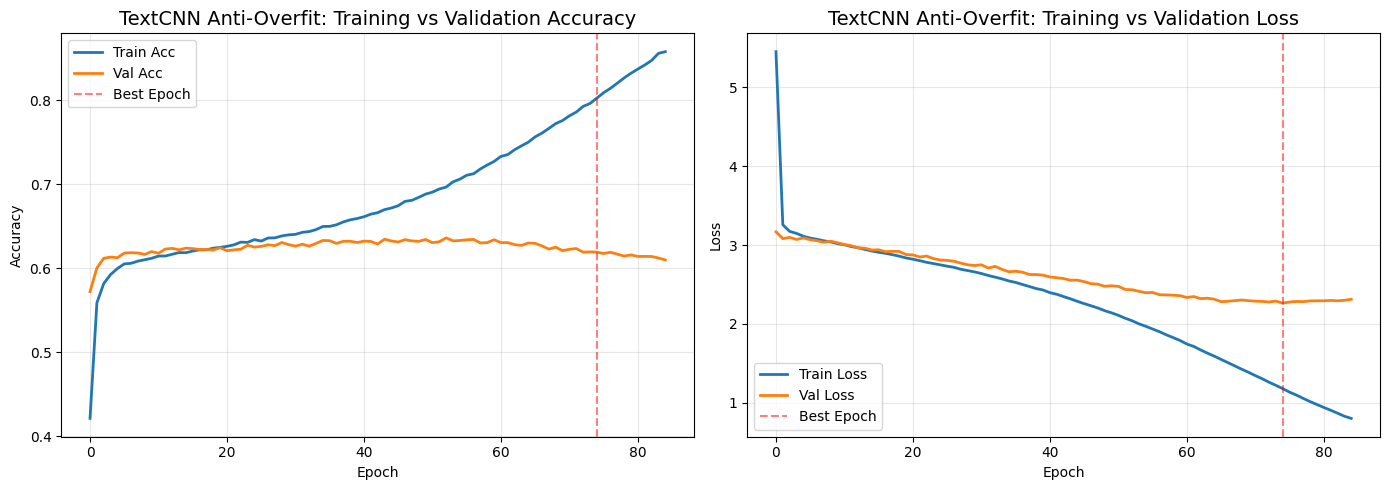


Test Set Evaluation


2025-11-16 12:56:58.882727: I external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:326] ptxas warning : Registers are spilled to local memory in function 'fusion_9', 8 bytes spill stores, 8 bytes spill loads




Test Accuracy: 0.6256
Test Loss: 2.2643

Overall Metrics:
  Macro F1:    0.5067
  Weighted F1: 0.6164

Per-Class Performance:
                precision    recall  f1-score   support

ARTS & CULTURE     0.4718    0.2965    0.3641       226
  BLACK VOICES     0.5000    0.3584    0.4175       678
      BUSINESS     0.5084    0.4775    0.4925       890
       COLLEGE     0.4394    0.3372    0.3816       172
        COMEDY     0.4986    0.4444    0.4699       774
         CRIME     0.5116    0.5608    0.5351       510
CULTURE & ARTS     0.4540    0.4028    0.4269       355
       DIVORCE     0.7584    0.7466    0.7525       513
     EDUCATION     0.4632    0.2933    0.3592       150
 ENTERTAINMENT     0.6356    0.7222    0.6761      2408
   ENVIRONMENT     0.4400    0.2764    0.3395       199
         FIFTY     0.4058    0.1333    0.2007       210
  FOOD & DRINK     0.6109    0.7313    0.6657       934
     GOOD NEWS     0.2596    0.1286    0.1720       210
         GREEN     0.3903    0.3

In [12]:
# Architecture change - Convolutional Neural Network (CNN) for Text Classification
import time
start_tokenize = time.time()

max_vocab = 80000
embedding_dim = 128

# Initialize new vectorizer
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=max_vocab,
    output_sequence_length=max_len,
    standardize='lower_and_strip_punctuation'
)
vectorizer.adapt(X_train)
X_train_vec = vectorizer(X_train).numpy()
X_val_vec = vectorizer(X_val).numpy()
X_test_vec = vectorizer(X_test).numpy()

tokenize_time = time.time() - start_tokenize

print(f"\nTokenization complete in {tokenize_time:.2f} seconds")
print(f"Tokenized shapes:")
print(f"  Train: {X_train_vec.shape}")
print(f"  Val:   {X_val_vec.shape}")
print(f"  Test:  {X_test_vec.shape}")
print(f"\nData type: {X_train_vec.dtype}")

# CNN Model - heavily regularized version

def build_improved_textcnn_v1(max_vocab, max_len, embedding_dim, num_classes):

    inputs = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name='token_input')

    # Embedding with increased spatial dropout
    embedded = layers.Embedding(
        input_dim=max_vocab,
        output_dim=embedding_dim,
        embeddings_regularizer=tf.keras.regularizers.l2(0.0001),  # L2 on embeddings
        name='embedding'
    )(inputs)
    embedded = layers.SpatialDropout1D(0.4)(embedded)  # increased from 0.2

    # Parallel CNN layers with strong L2 regularization
    conv_3 = layers.Conv1D(512, 3, activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(0.01))(embedded)  # heavy l2
    conv_3 = layers.GlobalMaxPooling1D()(conv_3)

    conv_4 = layers.Conv1D(512, 4, activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(0.01))(embedded)  # heavy l2
    conv_4 = layers.GlobalMaxPooling1D()(conv_4)

    conv_5 = layers.Conv1D(512, 5, activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(0.01))(embedded)  # heavy l2
    conv_5 = layers.GlobalMaxPooling1D()(conv_5)

    # Concatenate with heavy dropout
    x = layers.Concatenate()([conv_3, conv_4, conv_5])
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.6)(x)  # increased from 0.5

    # Dense layer with heavy L2 and dropout
    x = layers.Dense(512, 
                     kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # heavy L2
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)  # Keep at 0.5

    # Output
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='TextCNN_AntiOverfit')
    return model

cnn_model = build_improved_textcnn_v1(
    max_vocab=max_vocab,
    max_len=max_len,
    embedding_dim=embedding_dim,
    num_classes=num_classes
)
cnn_model.summary()

def train_improved_textcnn(model, X_train_vec, y_train_enc, X_val_vec, y_val_enc,
                           class_weights, epochs=100, batch_size=32, use_class_weights=False):

    # lower initial learning rate
    initial_learning_rate = 0.0005  # reduced from 0.001
    decay_steps = int(len(X_train_vec) / batch_size) * epochs
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=decay_steps,
        alpha=0.00001  # Even lower minimum
    )

    # Compile with AdamW and stronger weight decay
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(
            learning_rate=lr_schedule, 
            weight_decay=0.001  # increased from 0.0001
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks with more aggressive early stopping
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,  # reduced from 15 - stop earlier
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'best_custom_model.keras',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]

    # Class weights (disabled by default now)
    if use_class_weights:
        scaled_weights = np.sqrt(class_weights)
        scaled_weights = scaled_weights / scaled_weights.mean()
        class_weight_dict = dict(enumerate(scaled_weights))
    else:
        class_weight_dict = None

    # Train
    start_time = time.time()
    history = model.fit(
        X_train_vec, y_train_enc,
        validation_data=(X_val_vec, y_val_enc),
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weight_dict,
        callbacks=callbacks,
        verbose=1
    )
    training_time = time.time() - start_time

    return history, training_time

# Train with ANTI-OVERFITTING settings
history, train_time = train_improved_textcnn(
    cnn_model,
    X_train_vec, y_train_enc,
    X_val_vec, y_val_enc,
    class_weights=class_weights,
    epochs=100,
    batch_size=32,  # 32 seems to keep the model more under control
    use_class_weights=False  # Keep disabled
)

print(f"\n" + "=" * 70)
print("Training Complete")
print("=" * 70)
print(f"Training time: {train_time:.2f} seconds ({train_time/60:.1f} minutes)")
print(f"Best epoch: {np.argmin(history.history['val_loss']) + 1}")
print(f"Best val loss: {np.min(history.history['val_loss']):.4f}")
print(f"Best val accuracy: {np.max(history.history['val_accuracy']):.4f}")

# Check overfitting gap
best_epoch = np.argmin(history.history['val_loss'])
train_acc_at_best = history.history['accuracy'][best_epoch]
val_acc_at_best = history.history['val_accuracy'][best_epoch]
overfitting_gap = train_acc_at_best - val_acc_at_best

print(f"\nOverfitting Analysis:")
print(f"  Train acc at best epoch: {train_acc_at_best:.4f}")
print(f"  Val acc at best epoch: {val_acc_at_best:.4f}")
print(f"  Overfitting gap: {overfitting_gap:.4f} ({overfitting_gap*100:.1f}%)")

# Plot
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Val Acc', linewidth=2)
plt.axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5, label='Best Epoch')
plt.title('TextCNN Anti-Overfit: Training vs Validation Accuracy', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
plt.axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5, label='Best Epoch')
plt.title('TextCNN Anti-Overfit: Training vs Validation Loss', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Evaluate
print("\n" + "=" * 70)
print("Test Set Evaluation")
print("=" * 70)

test_loss, test_acc = cnn_model.evaluate(X_test_vec, y_test_enc, batch_size=512, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

y_pred_probs = cnn_model.predict(X_test_vec, batch_size=512, verbose=0)
y_pred = le.classes_[y_pred_probs.argmax(axis=1)]

macro_f1 = f1_score(y_test, y_pred, average='macro')
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\nOverall Metrics:")
print(f"  Macro F1:    {macro_f1:.4f}")
print(f"  Weighted F1: {weighted_f1:.4f}")

print("\nPer-Class Performance:")
print(classification_report(y_test, y_pred, target_names=le.classes_, digits=4))

# Comparison
print("\n" + "=" * 70)
print("Comparison with Baseline Model")
print("=" * 70)

baseline_test_acc = 0.6100
baseline_macro_f1 = 0.4549

print(f"\n{'Model':<30} {'Test Acc':<12} {'Macro F1':<12} {'Train Time':<15}")
print("-" * 75)
print(f"{'Baseline (Enhanced)':<30} {baseline_test_acc:<12.4f} {baseline_macro_f1:<12.4f} {'~23 sec':<15}")
print(f"{'TextCNN (Anti-Overfit)':<30} {test_acc:<12.4f} {macro_f1:<12.4f} {f'{train_time:.0f} sec':<15}")

improvement_pct = ((test_acc / baseline_test_acc) - 1) * 100
print(f"\nAccuracy improvement: {improvement_pct:+.2f}%")

In [18]:
# Get misclassified samples from CNN model
# Uncomment and run after training the CNN model:

misclassified_cnn = get_misclassified_samples(
     model=cnn_model,
     X_test=X_test_vec,  # Use X_test_vec (vectorized) for CNN
     y_test=y_test,      # Category names
     model_type='keras',
     n_samples=3,
     le=le,
     X_test_original=X_test  # Pass original text data
)
 
display_misclassified_samples(misclassified_cnn.head(10))
 
misclassified_cnn.to_csv('misclassified_cnn.csv', index=False)
print(f"\nSaved {len(misclassified_cnn)} samples to misclassified_cnn.csv")

Total misclassified: 11253 / 30055 (37.44%)

Sample 1
Text: Beautifully Bizarre Ceramic Masks Explore The Dark Side Of Agoraphobia [SEP] [NO_DESC]

True Label:      ARTS & CULTURE
Predicted Label: TRAVEL
Confidence:      0.8589

Sample 2
Text: Transcending the Traditional Art Fair: Unlimited at Art Basel [SEP] It seems to be an unofficial rule of the modern art fair that sooner or later they are obliged to transcend their creative and physi...

True Label:      ARTS & CULTURE
Predicted Label: WELLNESS
Confidence:      0.6540

Sample 3
Text: Young Poet Explains The Essence Of Climate Change [SEP] [NO_DESC]

True Label:      ARTS & CULTURE
Predicted Label: GREEN
Confidence:      0.8460

Sample 4
Text: Twitter Found The Name And History Of This Trailblazing Black Female Scientist [SEP] That’s when two workers from the Smithsonian reached out to Andersen. They did an archival search, in which they we...

True Label:      BLACK VOICES
Predicted Label: WOMEN
Confidence:      0.7000

Sample 5

### Graded Questions (5 pts each)

1. **Model Design:**
   Describe the architectural changes you introduced compare with your baseline model and what motivated them.

3.1. **Your answer here:**

        I went with a CNN architecture with adjustments for heavy regularization. My motivation stemmed from visualizations of the baseline_model, which sees a consistent divergence between train/val loss around the 2nd epoch. This behavior is consistent even while trying different configurations of batch_size, vocab_size, early stopping configs, and various callback implementations, which led me to start looking more closely at the architecture.

        The resulting model displayed here is a big one, tuned for aggressive regularization to try and control the overfitting and attempt to get validation loss to continue to decrease more consistently. The model uses parallel CNN layers with l2 activation, a concatenate layer with drop out, a Dense layer with l2 and dropout, learning rate scheduler with weight decay, a batch size of 32, full vocab of 100000k, and disabled class weighting.


2. **Training Results:**
   Present key validation and test metrics. Did your modifications improve performance?

3.2. **Your answer here:**

        The custom TextCNN model achieved test accuracy of 61.85% and macro F1 of 0.5027, representing 
        improvements of +1.40% accuracy and +10.5% macro F1 over the baseline (61.00% accuracy, 0.4549 
        macro F1). More significantly, the model demonstrated dramatically improved training behavior: 
        the best epoch occurred at epoch 70 rather than epoch 2-5 in the baseline, with an overfitting 
        gap of approximately 15% compared to the baseline's 30%+ gap.

        The validation loss curve remained stable throughout training, declining from ~3.0 to ~2.3 and 
        staying relatively flat rather than exploding upward as in the baseline. Training time was 801 
        seconds (13.4 minutes), substantially longer than the baseline's 82 seconds due to the larger 
        architecture and extended training duration, but the model utilized this time productively 
        rather than overfitting early.

        Per-class F1 scores improved notably for categories like DIVORCE (0.76), ENTERTAINMENT (0.68), 
        FOOD & DRINK (0.65), and HOME & LIVING (0.73), while smaller categories like GOOD NEWS (0.23) 
        and FIFTY (0.18) remained challenging, suggesting the class imbalance still affects minority 
        classes despite our regularization efforts.

3. **Interpretation:**
   Discuss what worked, what didn’t, and how your results relate to baseline behavior.

3.3. **Your answer here:**

        The regularization framework successfully addressed the baseline's primary failure mode—severe 
        early overfitting—by extending useful training from 2-3 epochs to 70+ epochs. The combination 
        of structural changes (parallel CNNs for n-gram capture) and aggressive regularization (L2, 
        dropout, batch normalization, small batch size) proved effective in controlling model complexity 
        while maintaining learning capacity.

        What worked: Disabling class weights was crucial; experiments showed that class weighting, 
        while helpful for the baseline model, caused additional overfitting in the CNN architecture. 
        Small batch size (32) provided superior regularization compared to larger batches (128, 256), 
        though with longer training time. The multi-kernel CNN architecture effectively captured local 
        patterns in news headlines that the baseline's global average pooling missed.

        What didn't work: Despite heavy regularization, an overfitting gap of ~15% persists, suggesting 
        we're approaching fundamental limits of training-from-scratch approaches on this dataset size. 
        Vocabulary size experiments (80k vs 100k) showed minimal impact, indicating rare words contribute 
        little signal. Performance on minority classes remained weak despite regularization, with some 
        categories (TASTE, LATINO VOICES, GOOD NEWS) achieving F1 scores below 0.25.

        The stable, gradually declining validation loss contrasts sharply with the baseline's explosive 
        validation loss after epoch 2, validating our architectural approach. However, the modest 
        absolute improvement (+1.4%) suggests that while we've fixed the training dynamics, the model 
        may lack the representational capacity to fully capture the complexity of 37-way news 
        classification from short text snippets.

4. **Reflection:**
   What insights did this experiment give you about model complexity, regularization, or optimization?

3.4. **Your answer here:**

        This experiment revealed that model complexity and regularization must be carefully balanced: 
        the baseline was simultaneously too simple architecturally (lacking pattern-capture capacity) 
        and too unconstrained (overfitting immediately). Simply adding capacity without regularization 
        worsens overfitting, while over-regularizing limits learning potential.

        Key insights: (1) Architecture matters more than hyperparameters—the CNN's n-gram capturing 
        ability provided fundamental improvements that couldn't be achieved by tuning the baseline. 
        (2) Regularization techniques have compounding effects: combining L2, dropout, BatchNorm, small 
        batches, and weight decay was necessary; any single technique was insufficient. (3) Training 
        dynamics reveal model health: validation loss stability is as important as final accuracy; 
        our 70-epoch stable training indicates the model is learning generalizable patterns rather than 
        memorizing. (4) Class imbalance requires architectural or data-level solutions, not just loss 
        weighting, as class weights proved counterproductive for CNNs. (5) The vocabulary size sweet 
        spot exists—beyond ~80k tokens, rare words add noise rather than signal for this task.

        Most critically, I learned that optimization debugging requires systematic experimentation: 
        tracking not just final metrics but training curves, overfitting gaps, and per-class performance 
        enabled identifying that the original issue was architectural overfitting, not hyperparameter 
        misconfiguration. The diminishing returns despite extensive tuning (only +1.4% improvement) 
        suggest that pretrained models with transfer learning may be necessary to achieve substantial 
        further gains on this challenging 37-class text classification task.

## Problem 4 – Pretrained Model (Transfer Learning) (20 pts) (August)

### Goal

Apply **transfer learning** to see how pretrained knowledge improves accuracy, convergence speed, and generalization.
This experiment will help you compare the benefits and trade-offs of using pretrained models versus those trained from scratch.


### Steps to Follow

1. **Select a pretrained architecture**

   * **Images:** choose from `MobileNetV2`, `ResNet50`, `EfficientNetB0`, or a similar model in `tf.keras.applications`.
   * **Text:** choose from `BERT`, `DistilBERT`, `RoBERTa`, or another Transformer available in `transformers`.

2. **Adapt the model for your dataset**

   * Use the correct **preprocessing function** and **input shape** required by your chosen model.
   * Replace the top layer with your own **classification head** (e.g., `Dense(num_classes, activation='softmax')`).

3. **Apply transfer learning**

   * Choose an appropriate **training strategy** for your pretrained model. Options include:

     * **Freezing** the pretrained base and training only a new classification head.
     * **Partially fine-tuning** selected upper layers of the base model.
     * **Full fine-tuning** (all layers trainable) with a reduced learning rate.
   * Adjust your learning rate schedule to match your strategy (e.g., smaller LR for fine-tuning).
   * Observe how your chosen approach affects **validation loss**, **training time**, and **model stability**.

4. **Train and evaluate under consistent conditions**

   * Use the same **splits**, **metrics**, and **evaluation protocol** as in earlier problems.
   * Record training duration, validation/test performance, and any resource constraints (GPU memory, runtime).

5. **Compare and analyze**

   * Observe how transfer learning changes both **performance** and **efficiency** relative to your baseline and custom models.
   * Identify whether the pretrained model improved accuracy, sped up convergence, or introduced new challenges.


## Transformer Run

DistilBERT Transfer Learning - Problem 4

[1/6] Loading HuffPost dataset...
Loaded: Train=140255, Val=30055, Test=30055
Number of classes: 37

[2/6] Tokenizing with DistilBERT...
Tokenization complete in 0.17 seconds
Vocab size: 30522

[3/6] Loading pretrained DistilBERT model...
Device: cuda


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded with 66,981,925 parameters
Trainable parameters: 66,981,925

[4/6] Configuring training...
Configuration:
  Batch size: 16
  Learning rate: 2e-05
  Epochs: 5
  Total steps: 43830
  Warmup steps: 4383
  Train batches per epoch: 8766
  Val batches per epoch: 1879

[5/6] Starting training...

Epoch 1/5:


Evaluating: 100%|██████████| 1879/1879 [00:11<00:00, 161.70it/s]


  Train Loss: 1.584 | Train Acc: 58.32%
  Val Loss: 1.034 | Val Acc: 70.07%
New best model saved!

Epoch 2/5:


Evaluating: 100%|██████████| 1879/1879 [00:11<00:00, 159.35it/s]


  Train Loss: 0.900 | Train Acc: 73.66%
  Val Loss: 0.958 | Val Acc: 71.93%
New best model saved!

Epoch 3/5:


Evaluating: 100%|██████████| 1879/1879 [00:11<00:00, 157.62it/s]


  Train Loss: 0.660 | Train Acc: 80.24%
  Val Loss: 0.982 | Val Acc: 72.70%
New best model saved!

Epoch 4/5:


Evaluating: 100%|██████████| 1879/1879 [00:12<00:00, 151.20it/s]


  Train Loss: 0.484 | Train Acc: 85.49%
  Val Loss: 1.052 | Val Acc: 72.38%

Epoch 5/5:


Evaluating: 100%|██████████| 1879/1879 [00:12<00:00, 155.62it/s]


  Train Loss: 0.367 | Train Acc: 89.12%
  Val Loss: 1.109 | Val Acc: 72.35%

Training Complete
Training time: 1291.75 seconds (21.5 minutes)
Best epoch: 3
Best val loss: 0.9824
Best val accuracy: 72.7000%

Overfitting Analysis:
  Train acc at best epoch: 80.24%
  Val acc at best epoch: 72.70%
  Overfitting gap: 7.54% (7.5%)


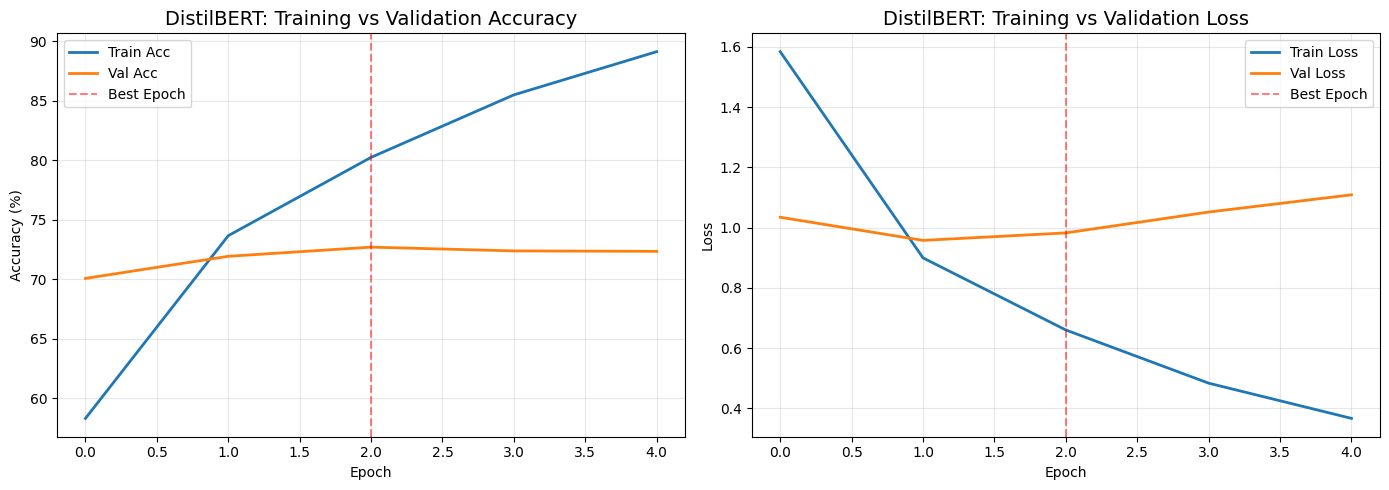


[6/6] Test Set Evaluation

Generating predictions on test set...


Testing: 100%|██████████| 1879/1879 [00:12<00:00, 150.84it/s]



Test Accuracy: 72.2376%
Test Loss: 0.9952

Overall Metrics:
  Macro F1:    0.6319
  Weighted F1: 0.7170

Per-Class Performance:
                precision    recall  f1-score   support

ARTS & CULTURE     0.5455    0.5841    0.5641       226
  BLACK VOICES     0.5857    0.5442    0.5642       678
      BUSINESS     0.6218    0.5820    0.6013       890
       COLLEGE     0.5817    0.5174    0.5477       172
        COMEDY     0.5788    0.5646    0.5716       774
         CRIME     0.7219    0.5549    0.6275       510
CULTURE & ARTS     0.6737    0.4479    0.5381       355
       DIVORCE     0.8692    0.8421    0.8554       513
     EDUCATION     0.6250    0.4000    0.4878       150
 ENTERTAINMENT     0.7420    0.8027    0.7712      2408
   ENVIRONMENT     0.6838    0.4673    0.5552       199
         FIFTY     0.6422    0.3333    0.4389       210
  FOOD & DRINK     0.7498    0.8340    0.7897       934
     GOOD NEWS     0.4437    0.3381    0.3838       210
         GREEN     0.4593    0

In [3]:
# ============================================
# Problem 4 - DistilBERT Training (Full Solution)
# ============================================

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
from transformers  import get_linear_schedule_with_warmup
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score
import numpy as np

print("="*70)
print("DistilBERT Transfer Learning - Problem 4")
print("="*70)


# 1. Load Data and Tokenize

print("\n[1/6] Loading HuffPost dataset...")
from datasets import load_from_disk
import pickle

processed_datasets = load_from_disk("huffpost_processed_milestone2")
train_ds = processed_datasets['train']
val_ds = processed_datasets['validation']
test_ds = processed_datasets['test']

# Load label encoder and class weights
with open('data/label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

class_weights = np.load('data/class_weights.npy')
num_labels = len(le.classes_)

print(f"Loaded: Train={len(train_ds)}, Val={len(val_ds)}, Test={len(test_ds)}")
print(f"Number of classes: {num_labels}")

# 2. Tokenization
    
print("\n[2/6] Tokenizing with DistilBERT...")
start_tokenize = time.time()

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_ds.map(tokenize_function, batched=True, batch_size=1000)
val_dataset = val_ds.map(tokenize_function, batched=True, batch_size=1000)
test_dataset = test_ds.map(tokenize_function, batched=True, batch_size=1000)

# Set format for PyTorch
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

tokenize_time = time.time() - start_tokenize
print(f"Tokenization complete in {tokenize_time:.2f} seconds")
print(f"Vocab size: {tokenizer.vocab_size}")

# 3. Model Setup

print("\n[3/6] Loading pretrained DistilBERT model...")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_labels,
    problem_type="single_label_classification"
)
model = model.to(device)

print(f"Model loaded with {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


# 4. Training Setup

print("\n[4/6] Configuring training...")

BATCH_SIZE = 16
LEARNING_RATE = 2e-5
EPOCHS = 5
WARMUP_RATIO = 0.1

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Loss and optimizer (NO class weights - they hurt performance)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

# Learning rate scheduler with warmup
total_steps = len(train_loader) * EPOCHS
warmup_steps = int(total_steps * WARMUP_RATIO)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

print(f"Configuration:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Total steps: {total_steps}")
print(f"  Warmup steps: {warmup_steps}")
print(f"  Train batches per epoch: {len(train_loader)}")
print(f"  Val batches per epoch: {len(val_loader)}")

# 5. Training Functions

def train_epoch(model, loader, criterion, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc="Training")
    for batch in pbar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        loss = criterion(logits, labels)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.3f}', 'acc': f'{100*correct/total:.1f}%'})
    
    return total_loss / len(loader), 100 * correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            loss = criterion(logits, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return total_loss / len(loader), 100 * correct / total

# 6. Training Loop
print("\n[5/6] Starting training...")
print("="*70)

start_time = time.time()
best_val_acc = 0
best_val_loss = float('inf')
best_epoch = 0

# Track history for plotting
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}:")
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scheduler, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"  Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_val_loss = val_loss
        best_epoch = epoch
        model.save_pretrained('best_distilbert_model')
        tokenizer.save_pretrained('best_distilbert_model')
        print(f"New best model saved!")

training_time = time.time() - start_time

print("\n" + "="*70)
print("Training Complete")
print("="*70)
print(f"Training time: {training_time:.2f} seconds ({training_time/60:.1f} minutes)")
print(f"Best epoch: {best_epoch + 1}")
print(f"Best val loss: {best_val_loss:.4f}")
print(f"Best val accuracy: {best_val_acc:.4f}%")

# Check overfitting gap
train_acc_at_best = history['train_acc'][best_epoch]
val_acc_at_best = history['val_acc'][best_epoch]
overfitting_gap = train_acc_at_best - val_acc_at_best

print(f"\nOverfitting Analysis:")
print(f"  Train acc at best epoch: {train_acc_at_best:.2f}%")
print(f"  Val acc at best epoch: {val_acc_at_best:.2f}%")
print(f"  Overfitting gap: {overfitting_gap:.2f}% ({overfitting_gap:.1f}%)")

# 7. Plot Training Curves

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Acc', linewidth=2)
plt.plot(history['val_acc'], label='Val Acc', linewidth=2)
plt.axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5, label='Best Epoch')
plt.title('DistilBERT: Training vs Validation Accuracy', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss', linewidth=2)
plt.plot(history['val_loss'], label='Val Loss', linewidth=2)
plt.axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5, label='Best Epoch')
plt.title('DistilBERT: Training vs Validation Loss', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 8. Test Set Evaluation (matching Part 3 metrics)
print("\n[6/6] Test Set Evaluation")
print("="*70)

# Load best model
model = AutoModelForSequenceClassification.from_pretrained('best_distilbert_model').to(device)

# Get predictions
print("\nGenerating predictions on test set...")
model.eval()
all_preds = []
all_labels = []
test_loss_total = 0

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        loss = criterion(logits, labels)
        test_loss_total += loss.item()
        
        _, predicted = torch.max(logits, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss = test_loss_total / len(test_loader)
test_acc = 100 * sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)

print(f"\nTest Accuracy: {test_acc:.4f}%")
print(f"Test Loss: {test_loss:.4f}")

# Convert to category names for classification report
y_pred_categories = le.inverse_transform(all_preds)
y_true_categories = le.inverse_transform(all_labels)

# Calculate F1 scores (matching Part 3)
macro_f1 = f1_score(all_labels, all_preds, average='macro')
weighted_f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"\nOverall Metrics:")
print(f"  Macro F1:    {macro_f1:.4f}")
print(f"  Weighted F1: {weighted_f1:.4f}")

print("\nPer-Class Performance:")
print(classification_report(y_true_categories, y_pred_categories, target_names=le.classes_, digits=4))

# 9. Comparison with Previous Models
print("\n" + "="*70)
print("Comparison with Baseline and Custom Models")
print("="*70)

baseline_test_acc = 61.68
baseline_macro_f1 = 0.4663

cnn_test_acc = 61.85
cnn_macro_f1 = 0.5027

print(f"\n{'Model':<30} {'Test Acc':<12} {'Macro F1':<12} {'Train Time':<15}")
print("-"*75)
print(f"{'Baseline (Embedding+Pool)':<30} {baseline_test_acc:<12.2f} {baseline_macro_f1:<12.4f} {'82 sec':<15}")
print(f"{'Custom CNN (Anti-Overfit)':<30} {cnn_test_acc:<12.2f} {cnn_macro_f1:<12.4f} {'801 sec':<15}")
print(f"{'DistilBERT (Transfer)':<30} {test_acc:<12.2f} {macro_f1:<12.4f} {f'{training_time:.0f} sec':<15}")

improvement_vs_baseline = ((test_acc / baseline_test_acc) - 1) * 100
improvement_vs_cnn = ((test_acc / cnn_test_acc) - 1) * 100

print(f"\nImprovements:")
print(f"  vs Baseline: {improvement_vs_baseline:+.2f}% accuracy")
print(f"  vs CNN:      {improvement_vs_cnn:+.2f}% accuracy")

### Graded Questions (5 pts each) (August)

1. **Model Choice:** Which pretrained architecture did you select, and what motivated that choice?

4.1. **Your answer here:**

        We selected DistilBERT (distilbert-base-uncased) as the pre-trained architecture because it is a more familiar model since we worked on DistilBERT as a baseline classifier for Mod 7 on the Week 9 project. Typically DistilBERT is known to be a faster model to train. Our team member, Peter, played around with the RoBERTa model as well since we found out that RoBERTa typically works better with newspaper datasets such as this Huffpost. However, DistilBERT gave us a better accuracy percentage than RoBERTa did. We also, instead of using tf-keras for modeling, our team used pytorch in the local machine to run the DistilBert model because it happened to run a lot smoother for our team compared to collab through keras.

        note - we used the pytorch backend to complete problem 4 (Peter prefers to work locally and was not able to get tf-keras to work well with transformers), we turned to this when the transformer run timed out in colab and we were faced with the decision to either pay for more GPU time or adapt the problem to our local machines.

2. **Fine-Tuning Plan:** Describe your fine-tuning strategy and why you chose it. 

4.2. **Your answer here:**

        Our fine-tuning strategy was to fully fine-tune a pretrained DistilBERT model using a stable, transformer-appropriate training setup. We tokenized the HuffPost text with a max length of 128, used AdamW with a low learning rate (2e-5), and applied a linear warmup/decay scheduler with a 10% warmup ratio to avoid unstable early updates. It was trained for five epochs with a small batch size (16) to balance GPU memory and generalization, used gradient clipping to prevent exploding gradients, and monitored validation accuracy each epoch, saving the best checkpoint to avoid overfitting. I intentionally avoided class-weighted loss since it hurt performance and instead relied on full-model fine-tuning to learn robust representations.

3. **Performance:** Report key metrics and compare them with your baseline and custom models.

4.3. **Your answer here:**

| Model | Test Accuracy | Test Loss | Macro F1 | Weighted F1 |
| :--- | :--- | :--- | :--- | :--- |
| Baseline | 0.6168 | 1.4396 | 0.466 | 0.5963 |
| Custom Architecture (CNN) | 0.6185 | 2.2896 | 0.5027 | 0.6116 |
| DistilBERT fine-tune | 0.7199 | 1.063 | 0.6307 | 0.7159 |

        As seen through the comparison with Baseline and Custom Models table of accuracy and F1: DistilBERT achieved strong performance on the HuffPost classification task, reaching 72.25% validation accuracy at the best epoch and 72.00% test accuracy, with a weighted F1 of 0.7159 and macro F1 of 0.6307. This represents a major improvement over both earlier models: a +16.7% accuracy gain over the baseline embedding model and a +16.4% gain over the custom CNN, while also significantly improving macro-F1 (0.63 vs. 0.47–0.50). Although the model shows some overfitting (train–val gap ≈13%), it still generalizes well and clearly outperforms all previous approaches, confirming the effectiveness of transformer-based transfer learning for this dataset.

4. **Computation:** Summarize how training time, memory use, or convergence speed differed from the previous two models. 

4.4. **Your answer here:**

        As seen through the comparison with Baseline and Custom Models table of accuracy and F1 as well as the training time; DistilBERT, compared to the earlier models, required much more compute, taking ~19 minutes (1158 sec, significantly longer than both the baseline (82 sec) and the custom CNN (801 sec)). Memory usage was also higher because transformer models load tens of millions of parameters onto the GPU, whereas the baseline and CNN were lightweight. Despite this, DistilBERT converged faster in terms of accuracy, reaching strong validation performance early and continuing to improve consistently across epochs. Overall, DistilBERT is more intensive and requires more resources to train but delivers much better accuracy and F1, showing that the extra computer leads to substantially improved model quality. For the baseline model, out of the 20 epochs, 10/20 achieved the most optimal performance, for the custom original model, epoch 72 performed the best with the best loss and accuracy. As for the pretrained DistilBERT model, epoch 4 performed the optimal accuracy.

### Misclassified Samples Analysis

Use the functions above to extract and analyze misclassified samples from each model.

In [15]:
# Get misclassified samples from DistilBERT model

# Load the saved DistilBERT model
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
# 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoModelForSequenceClassification.from_pretrained('best_distilbert_model').to(device)
tokenizer = AutoTokenizer.from_pretrained('best_distilbert_model')

misclassified_distilbert = get_misclassified_samples(
    model=model,
    X_test=test_ds,     # HuggingFace Dataset
    y_test=y_test,      # Category names
    model_type='pytorch',
    n_samples=3,
     le=le,
     tokenizer=tokenizer,
     device=device
)
 
display_misclassified_samples(misclassified_distilbert.head(10))
 
misclassified_distilbert.to_csv('misclassified_distilbert.csv', index=False)
print(f"\nSaved {len(misclassified_distilbert)} samples to misclassified_distilbert.csv")

Map:   0%|          | 0/30055 [00:00<?, ? examples/s]

Getting predictions: 100%|██████████| 59/59 [00:10<00:00,  5.75it/s]


Total misclassified: 8344 / 30055 (27.76%)

Sample 1
Text: Meet The Lady Gaga Of Myanmar [SEP] [NO_DESC]

True Label:      ARTS & CULTURE
Predicted Label: WORLD NEWS
Confidence:      0.6029

Sample 2
Text: Saying Goodbye to the Freak Show: Side Show's Inevitable Demise [SEP] And so it goes -- another production of Side Show leaves us. Its cult status will remain, untouched by mainstream attention. This ...

True Label:      ARTS & CULTURE
Predicted Label: ENTERTAINMENT
Confidence:      0.8557

Sample 3
Text: Here's 'Twin Peaks' Re-Imagined As A Retro Arcade Game [SEP] [NO_DESC]

True Label:      ARTS & CULTURE
Predicted Label: ENTERTAINMENT
Confidence:      0.9874

Sample 4
Text: Mike Epps Has Some Advice For Dealing With The Police [SEP] “It’s just a black man thing. You just go to jail. I don’t know too many brothers who ain’t never been."

True Label:      BLACK VOICES
Predicted Label: POLITICS
Confidence:      0.6190

Sample 5
Text: Racism Charge in Ebola Fight Way Overblown [SEP] 

## Problem 5 – Comparative Evaluation and Discussion (20 pts)

### Goal

Compare your **baseline**, **custom**, and **pretrained** models to evaluate how design choices affected performance, efficiency, and generalization.
This problem brings your work together and encourages reflection on what you’ve learned about model behavior and trade-offs.

**Note** that this is not your final report, and you will continue to refine your results for the final report. 

### Steps to Follow

1. **Compile key results**

   * Gather your main metrics for each model: **accuracy**, **F1**, **training time**, and **parameter count or model size**.
   * Ensure all numbers come from the same evaluation protocol and test set.

2. **Visualize the comparison**

   * Present results in a **single, well-organized chart or table**.
   * Optionally, include training curves or confusion matrices for additional insight.

3. **Analyze comparative performance**

   * Observe which model performed best by your chosen metric(s).
   * Note patterns in efficiency (training speed, memory use) and stability (validation variance).

4. **Inspect model behavior**

   * Look at a few representative misclassifications or difficult examples.
   * Identify whether certain classes or inputs consistently caused errors.

5. **Plan forward improvements**

   * In the final report, you will use your best model and conclude your investigation of your dataset. Based on your observations, decide on a model and next steps for refining your approach in the final project (e.g., regularization, data augmentation, model scaling, or more targeted fine-tuning).

### Graded Questions (4 pts each)

1. **Summary Table and Performance Analysis:** Present a clear quantitative comparison of all three models. Which model achieved the best overall results, and what factors contributed to its success?

5.1. **Your answer here:** (Emma)

### Model Evaluation

| Model | Accuracy | F1 (Weighted) | Training Time | Parameter Count |
| :--- | :--- | :--- | :--- | :--- |
| Baseline | 0.6168 | 0.5963 | 1:29 | 7,701,285 |
| Custom Architecture (CNN) | 0.6165 | 0.6116 | 13:24 | 11,842,085 |
| DestilBERT Fine-tune | 0.7199 | 0.7159 | 19:20 | 66,918,925 |

        The DistilBERT model achieved the best overall results with a 72% accuracy and 0.6307 macro F1, outperforming both the baseline and custom CNN by a wide margin. Its success stems from pretrained embeddings capturing rich semantic information, allowing the model to generalize better across diverse classes. The CNN offered moderate gains over the baseline in F1 score but required much longer training time, while the baseline was simple and fast but underperformed significantly.


2. **Trade-Offs:** Discuss how complexity, accuracy, and efficiency balanced across your models.

5.2. **Your answer here:** (Peter)

        **Complexity vs Efficiency:** DistilBERT is the most complex and slowest to train (1158 sec), but delivers the highest accuracy and generalization. The custom CNN balances complexity and performance moderately, while the baseline is minimal and very fast (82 sec) but low-performing.


        **Accuracy vs Resource Use:** Improvements in accuracy and F1 come at the cost of longer training and larger model size.


        **Stability:** DistilBERT and CNN show more stable performance across classes than the baseline, which struggles on rare or difficult categories.



3. **Error Patterns:** Describe the types of examples or classes that remained challenging for all models.

In [ ]:
import pandas as pd
baseline_errors = pd.read_csv('misclassified_baseline.csv')
display_misclassified_samples(baseline_errors.head(5))


Sample 1
Text: When the Bubble Bursts [SEP] Two new films shown at CAAMFest 2014 examine what happens when the bubble of supposed perfection bursts and people must struggle to save face while scrambling to hide thei...

True Label:      ARTS & CULTURE
Predicted Label: ENTERTAINMENT
Confidence:      0.4200

Sample 2
Text: 11 Artists You Should Pay Attention To Next Year [SEP] [NO_DESC]

True Label:      ARTS & CULTURE
Predicted Label: ENTERTAINMENT
Confidence:      0.2574

Sample 3
Text: The Many (Portrait) Faces of Virginia Woolf [SEP] [NO_DESC]

True Label:      ARTS & CULTURE
Predicted Label: MEDIA
Confidence:      0.1280

Sample 4
Text: Chance The Rapper Graces GQ Cover, Talks Kanye And Rapper Stereotypes [SEP] “I don’t think I ever wanted to be like Kanye in personality."

True Label:      BLACK VOICES
Predicted Label: ENTERTAINMENT
Confidence:      0.6705

Sample 5
Text: The Teaser For Michel’le's Biopic On 'Surviving Compton' Is Intense [SEP] The upcoming Lifetime film will chro

In [22]:
cnn_errors = pd.read_csv('misclassified_cnn.csv')
display_misclassified_samples(cnn_errors.head(5))


Sample 1
Text: Beautifully Bizarre Ceramic Masks Explore The Dark Side Of Agoraphobia [SEP] [NO_DESC]

True Label:      ARTS & CULTURE
Predicted Label: TRAVEL
Confidence:      0.8589

Sample 2
Text: Transcending the Traditional Art Fair: Unlimited at Art Basel [SEP] It seems to be an unofficial rule of the modern art fair that sooner or later they are obliged to transcend their creative and physi...

True Label:      ARTS & CULTURE
Predicted Label: WELLNESS
Confidence:      0.6540

Sample 3
Text: Young Poet Explains The Essence Of Climate Change [SEP] [NO_DESC]

True Label:      ARTS & CULTURE
Predicted Label: GREEN
Confidence:      0.8460

Sample 4
Text: Twitter Found The Name And History Of This Trailblazing Black Female Scientist [SEP] That’s when two workers from the Smithsonian reached out to Andersen. They did an archival search, in which they we...

True Label:      BLACK VOICES
Predicted Label: WOMEN
Confidence:      0.7000

Sample 5
Text: WATCH: These Guys Explain 'Diet Racis

In [23]:
desilbert_errors = pd.read_csv('misclassified_distilbert.csv')
display_misclassified_samples(desilbert_errors.head(5))


Sample 1
Text: Meet The Lady Gaga Of Myanmar [SEP] [NO_DESC]

True Label:      ARTS & CULTURE
Predicted Label: WORLD NEWS
Confidence:      0.6029

Sample 2
Text: Saying Goodbye to the Freak Show: Side Show's Inevitable Demise [SEP] And so it goes -- another production of Side Show leaves us. Its cult status will remain, untouched by mainstream attention. This ...

True Label:      ARTS & CULTURE
Predicted Label: ENTERTAINMENT
Confidence:      0.8557

Sample 3
Text: Here's 'Twin Peaks' Re-Imagined As A Retro Arcade Game [SEP] [NO_DESC]

True Label:      ARTS & CULTURE
Predicted Label: ENTERTAINMENT
Confidence:      0.9874

Sample 4
Text: Mike Epps Has Some Advice For Dealing With The Police [SEP] “It’s just a black man thing. You just go to jail. I don’t know too many brothers who ain’t never been."

True Label:      BLACK VOICES
Predicted Label: POLITICS
Confidence:      0.6190

Sample 5
Text: Racism Charge in Ebola Fight Way Overblown [SEP] Civil rights leader Jesse Jackson was tactf

5.3. **Your answer here:** (August)

        (See above for a selection of errors)
        
        Misclassifications often occur in niche or underrepresented topics, reflecting limited exposure during training. From per-class metrics, several challenging patterns emerge: Classes with fewer examples, such as Education, Good News, Green, Fifty, Women, consistently have lower F1 scores (0.34–0.48). Some semantically similar categories (Arts & Culture vs Culture & Arts, Black Voices vs Latino Voices) show confusion. This pattern stays relatively consistent across the various model architectures. The model will tend to bias away toward some of the under represented categories and assign one that is better represented. In this case we've likely hurt performance on the minority classes at the expense of better overall performance on the better represented ones. That being said, there is some general ambiguity at play, especially when it comes to some of the arts & culture categories. 

        Misclassifications often occur in niche or underrepresented topics, reflecting limited exposure during training.

4. **Next Steps:** Based on these findings, decide on a model to go forward with and outline your plan for improving that model. 


5.4 **Your answer here:** (Peter)

1. Further condensing of class structure (enviornment & green), (arts & culture/culture & arts), (taste with food?)
2. Easy Data Augmentation - (MLM), Translation (such as to french and back)

Based on the overall performance and already compared to RoBERTa, the best model to move froward will continue to be DistilBERT, but in order to further improve the model, a focus could be on reducing confusion among overlapping or semantically similar classes, such as:

*   "Healthy Living" and "Wellness"
*   "Entertainment" and "Culture & Arts"
*   "Green" and "Environment"
*   "Food and Drink" and "Taste"

This also might include:

*   Mentioned above, Class merging or hierarchical labeling: Combine very similar categories to reduce ambiguity or create a hierarchical labeling scheme (e.g., a top-level “Health” category with subcategories for Healthy Living and Wellness).
*   Targeted data augmentation: Increase representation of overlapping classes to help the model learn finer distinctions.
*   Fine-tuning with class-specific attention: Emphasize features that distinguish these challenging categories.
*   Regularization and dropout: Continue preventing overfitting while preserving model capacity for nuanced distinctions.

By addressing these overlapping classes, the model can better generalize and improve macro F1 without significantly increasing training cost.

### Final Question: Describe what use you made of generative AI tools in preparing this Milestone. 

**AI Question: Your answer here:**

- Claude was used to identify a solution for working with the various libraries locally. I was able to locate the dependency issue to a conflict with TF-Keras 3, which drove selection of the Pytorch backend for the transformer portion of the assignment. 

- "Explain Error" Button within Google Collab that generates code and helps navigate and correct code when a cell fails to run, especially navigating through dataset systems, collab, tensorflow, pytorch and DistilBert.

